In [1]:
import tensorflow as tf
import cv2
import numpy as np
from tensorflow import keras
from pathlib import Path
from natsort import natsorted

In [2]:
batch_size=16
patch_size=16
img_size=128
num_patches=(img_size//patch_size)**2
p_dim=256
heads_att=12
num_encoder=12
mlp_head=3072

In [3]:
target_class={0:"Normal",1:"Tuberculosis"}

In [4]:
Normal_dir=Path("TB_Chest_Radiography_Database/Normal/")
TB_dir=Path("TB_Chest_Radiography_Database/Tuberculosis/")

In [5]:
Normal_images:list=natsorted(list(map(str, list(Normal_dir.glob("*.png")))))
TB_images:list=natsorted(list(map(str, list(TB_dir.glob("*.png")))))

In [6]:
Normal_labels:list=[0]*len(Normal_images)
TB_labels:list=[1]*len(TB_images)

In [7]:
images=np.array(Normal_images+TB_images)
labels=np.array(Normal_labels+TB_labels)
images.shape, labels.shape

((4200,), (4200,))

In [8]:
from sklearn.model_selection import train_test_split

In [9]:
x_train, x_valid, y_train, y_valid = train_test_split(images,labels,test_size=0.2,random_state=42)
x_valid,x_test,y_valid,y_test=train_test_split(x_valid,y_valid,test_size=0.5,random_state=42)
(x_train.shape,x_valid.shape,x_test.shape)

((3360,), (420,), (420,))

In [10]:
import matplotlib.pyplot as plt

(-0.5, 511.5, 511.5, -0.5)

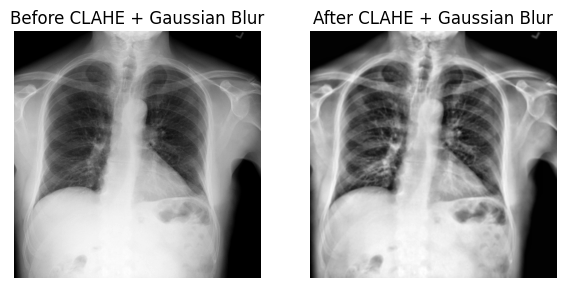

In [11]:
image_1=x_train[0]
image_1=cv2.imread(image_1)
image_1=cv2.cvtColor(image_1,cv2.COLOR_BGR2GRAY)
clahe=cv2.createCLAHE(2,(16,16))
image_1_preprocessed=cv2.GaussianBlur(image_1,(5,5),0)
image_1_preprocessed=clahe.apply(image_1_preprocessed)
_, ax = plt.subplots(1, 2, figsize=(7, 7))
ax[0].imshow(image_1,cmap='gray')
ax[0].set_title("Before CLAHE + Gaussian Blur")
ax[0].axis("off")
ax[1].imshow(image_1_preprocessed,cmap='gray')
ax[1].set_title("After CLAHE + Gaussian Blur")
ax[1].axis("off")

In [12]:
def image_preprocessing(path):
    img=cv2.imread(path)
    img=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    clahe=cv2.createCLAHE(3,(16,16))
    img=cv2.GaussianBlur(img,(5,5),0)
    img=clahe.apply(img)
    img=cv2.resize(img,(img_size,img_size))
    img=img.reshape(img_size,img_size,1)
    img=(img-np.mean(img,axis=(0,1),keepdims=True))/(np.std(img,axis=(0,1),keepdims=True)+1e-8)
    return img

In [13]:
x_train=np.array(list(map(image_preprocessing,x_train)))
x_train.shape

(3360, 128, 128, 1)

In [14]:
x_valid=np.array(list(map(image_preprocessing,x_valid)))
x_valid.shape

(420, 128, 128, 1)

In [15]:
x_test=np.array(list(map(image_preprocessing,x_test)))
x_test.shape

(420, 128, 128, 1)

In [16]:
train_dataset=tf.data.Dataset.from_tensor_slices((x_train,y_train)).shuffle(5000,seed=42).batch(batch_size).prefetch(tf.data.AUTOTUNE)
validation_dataset=tf.data.Dataset.from_tensor_slices((x_valid,y_valid)).batch(batch_size).prefetch(tf.data.AUTOTUNE)
test_dataset=tf.data.Dataset.from_tensor_slices((x_test,y_test)).batch(batch_size).prefetch(tf.data.AUTOTUNE)

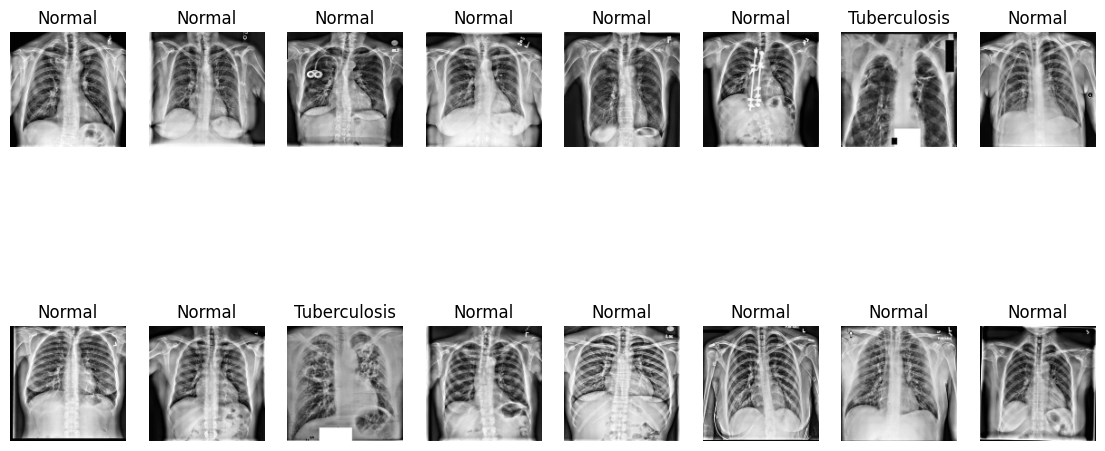

In [17]:
_, ax = plt.subplots(2, 8, figsize=(14, 7))
for batch in train_dataset.take(1):
    images = batch[0]
    labels = batch[1]
    for i in range(batch_size):
        img = images[i].numpy()
        label=labels[i].numpy()
        ax[i//8,i%8].imshow(img,cmap='gray')
        ax[i//8,i%8].set_title(target_class[label])
        ax[i//8,i%8].axis("off")

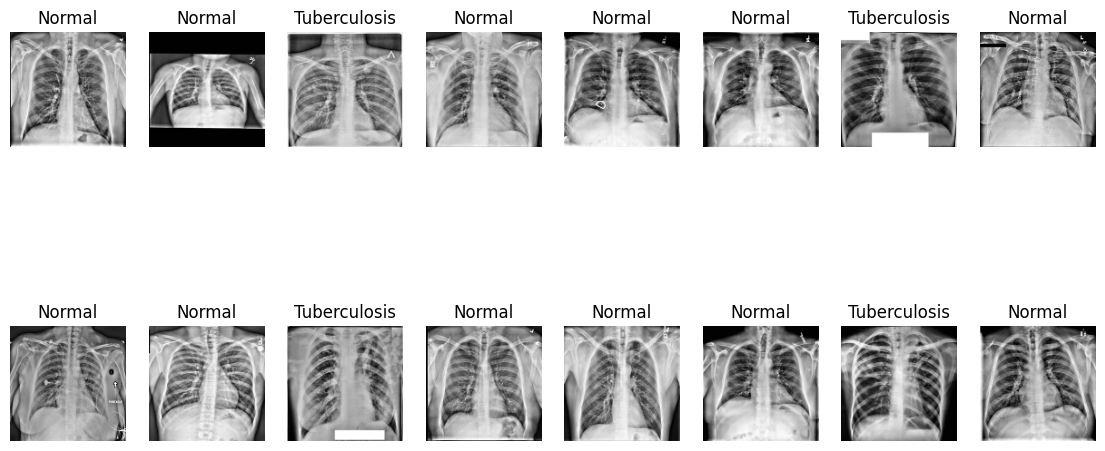

In [18]:
_, ax = plt.subplots(2, 8, figsize=(14, 7))
for batch in validation_dataset.take(1):
    images = batch[0]
    labels = batch[1]
    for i in range(batch_size):
        img = images[i].numpy()
        label=labels[i].numpy()
        ax[i//8,i%8].imshow(img,cmap='gray')
        ax[i//8,i%8].set_title(target_class[label])
        ax[i//8,i%8].axis("off")

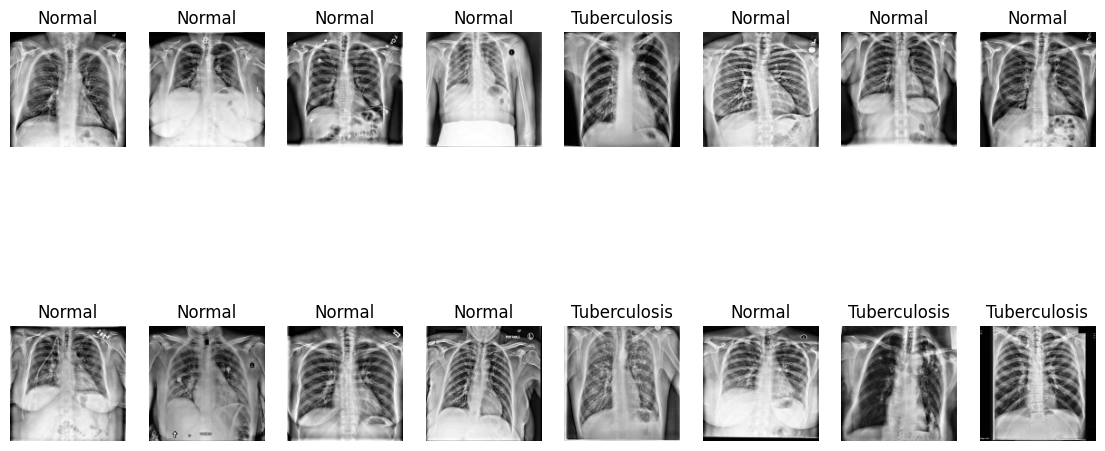

In [19]:
_, ax = plt.subplots(2, 8, figsize=(14, 7))
for batch in test_dataset.take(1):
    images = batch[0]
    labels = batch[1]
    for i in range(batch_size):
        img = images[i].numpy()
        label=labels[i].numpy()
        ax[i//8,i%8].imshow(img,cmap='gray')
        ax[i//8,i%8].set_title(target_class[label])
        ax[i//8,i%8].axis("off")

In [20]:
class Patches(keras.layers.Layer):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size
    
    def get_config(self):
        config=super().get_config()
        config.update({
            "patch_size":self.patch_size
        })
        return config

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

Image size: 128 X 128
Patch size: 16 X 16
Patches per image: 64
Elements per patch: 256


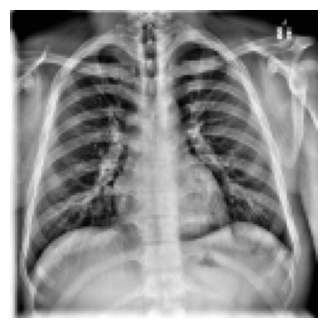

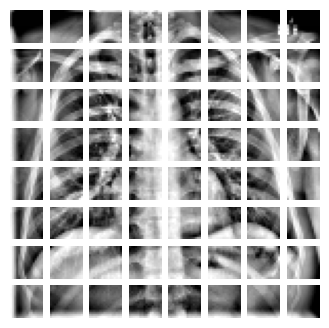

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 4))
image = x_valid[np.random.choice(range(x_valid.shape[0]))]
plt.imshow(image,cmap='gray')
plt.axis("off")

image=tf.convert_to_tensor([image])

patches = Patches(patch_size)(image)
print(f"Image size: {img_size} X {img_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 1))
    plt.imshow(patch_img.numpy(),cmap='gray')
    plt.axis("off")

In [22]:
class PatchEncoder(keras.layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.num_patches = num_patches
        self.projection_dim=projection_dim
        self.projection = keras.layers.Dense(units=self.projection_dim)
        self.position_embedding = keras.layers.Embedding(
            input_dim=num_patches+1, output_dim=self.projection_dim
        )
        w=tf.random.normal((1,p_dim))
        self.cls_token=tf.Variable(w,trainable=True)
    
    def get_config(self):
        config=super().get_config()
        config.update({
            "num_patches":self.num_patches,
            "projection_dim":self.projection_dim
        })
        return config

    def call(self, patch):
        batch_size=tf.shape(patch)[0]
        cls_token=tf.tile(self.cls_token,multiples=[batch_size,1])
        cls_token=tf.reshape(cls_token,(batch_size,1,p_dim))
        projection=self.projection(patch)
        projection=tf.concat([cls_token,projection],axis=1)
        positions = tf.range(start=0, limit=self.num_patches+1, delta=1)
        encoded = projection + self.position_embedding(positions)
        return encoded

In [23]:
def mlp(x, hidden_units):
    for units in hidden_units:
        x = keras.layers.Dense(units, activation=tf.nn.gelu)(x)
        x = keras.layers.Dropout(0.1)(x)
    return x

In [24]:
def build_model():
    inputs=keras.layers.Input(shape=(img_size,img_size,1))
    patches=Patches(patch_size)(inputs)
    encoded=PatchEncoder(num_patches,p_dim)(patches)
    
    for _ in range(num_encoder):
        x1=keras.layers.LayerNormalization()(encoded)
        attention=keras.layers.MultiHeadAttention(num_heads=heads_att,key_dim=p_dim)(x1,x1)
        x2=keras.layers.Add()([attention,encoded])
        x3=keras.layers.LayerNormalization()(x2)
        x3=mlp(x3,[2*p_dim,p_dim])
        encoded=keras.layers.Add()([x3,x2])
    
    rep=encoded[:,0] #z^0_L (cls_token)
    rep=keras.layers.LayerNormalization()(rep) #y=LN(z^0_L)

    output=keras.layers.Dense(1,activation='sigmoid')(rep)

    model=keras.Model(inputs=inputs,outputs=output)
    opt = keras.optimizers.Adam(decay=0.03)
    model.compile(optimizer=opt,
                  loss=keras.losses.BinaryFocalCrossentropy(),
                  metrics=[keras.metrics.Recall(),
                           keras.metrics.BinaryAccuracy()])
    return model

In [25]:
model=build_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 patches_1 (Patches)            (None, None, 256)    0           ['input_1[0][0]']                
                                                                                                  
 patch_encoder (PatchEncoder)   (None, 65, 256)      82688       ['patches_1[0][0]']              
                                                                                                  
 layer_normalization (LayerNorm  (None, 65, 256)     512         ['patch_encoder[0][0]']      

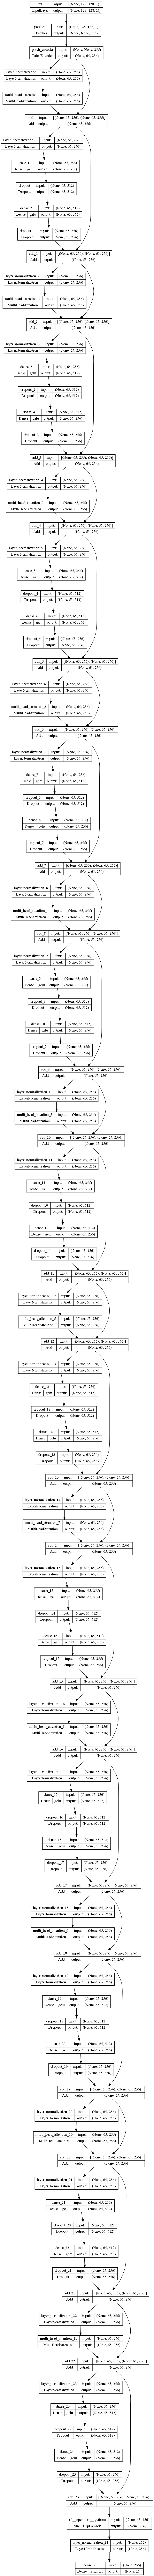

In [26]:
keras.utils.plot_model(model,show_shapes=True,show_layer_activations=True)

In [27]:
early_stop=keras.callbacks.EarlyStopping(monitor='val_loss',restore_best_weights=True,patience=10)
lr_scheduler=keras.callbacks.ReduceLROnPlateau(monitor='val_loss',factor=0.5,patience=3,verbose=1,min_lr=1e-5)

In [28]:
history=model.fit(train_dataset,
                  validation_data=validation_dataset,
                  epochs=200,
                  callbacks=[early_stop,lr_scheduler])

Epoch 1/200
210/210 [==============================] - 60s 233ms/step - loss: 0.2032 - recall: 0.1705 - binary_accuracy: 0.8161 - val_loss: 0.0813 - val_recall: 0.7324 - val_binary_accuracy: 0.8952 - lr: 0.0010
Epoch 2/200
210/210 [==============================] - 47s 225ms/step - loss: 0.0807 - recall: 0.4920 - binary_accuracy: 0.8774 - val_loss: 0.0600 - val_recall: 0.5775 - val_binary_accuracy: 0.9190 - lr: 0.0010
Epoch 3/200
210/210 [==============================] - 48s 227ms/step - loss: 0.0674 - recall: 0.6163 - binary_accuracy: 0.9015 - val_loss: 0.0469 - val_recall: 0.8592 - val_binary_accuracy: 0.9500 - lr: 0.0010
Epoch 4/200
210/210 [==============================] - 47s 225ms/step - loss: 0.0544 - recall: 0.7069 - binary_accuracy: 0.9253 - val_loss: 0.0617 - val_recall: 0.4225 - val_binary_accuracy: 0.9024 - lr: 0.0010
Epoch 5/200
210/210 [==============================] - 47s 226ms/step - loss: 0.0466 - recall: 0.7513 - binary_accuracy: 0.9345 - val_loss: 0.0389 - val_rec

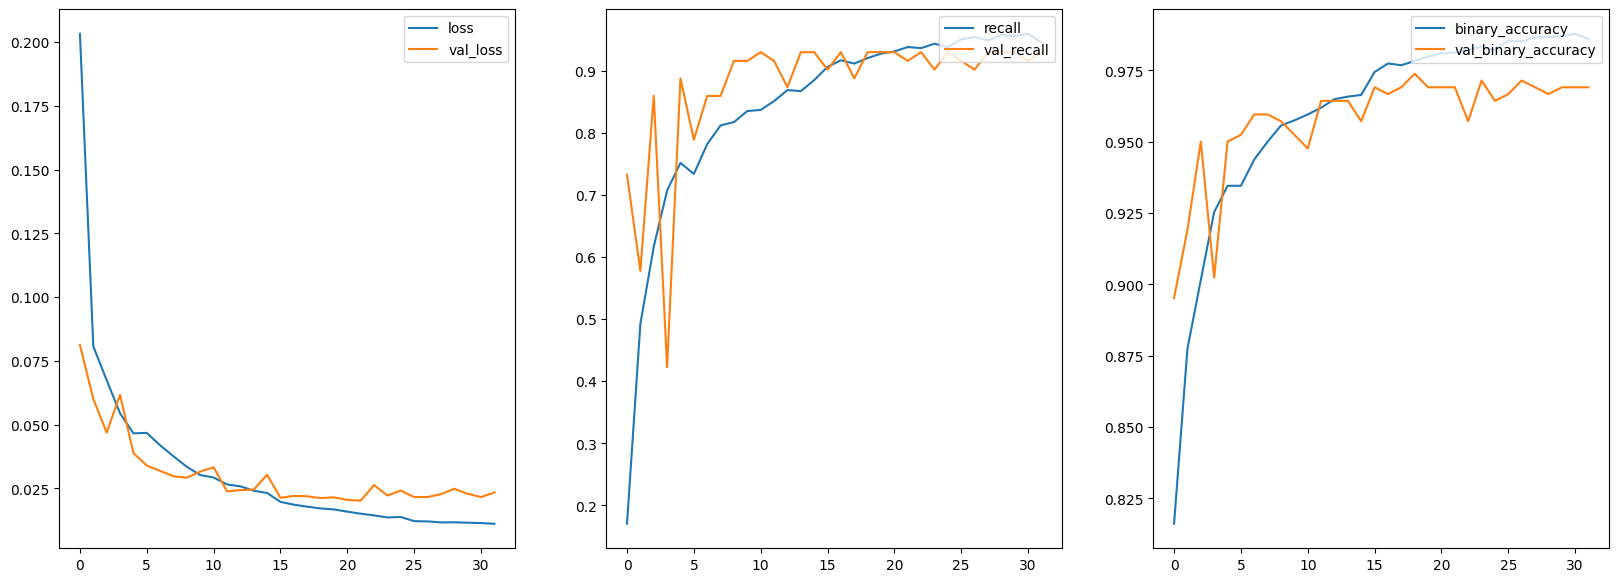

In [29]:
_, ax = plt.subplots(1, 3, figsize=(20,7))
loss = history.history['loss']
val_loss = history.history['val_loss']
recall=history.history['recall']
val_recall=history.history['val_recall']
binary_accuracy=history.history['binary_accuracy']
val_binary_accuracy=history.history['val_binary_accuracy']
epochs = range(len(loss))

ax[0].plot(epochs, loss)
ax[0].plot(epochs, val_loss)
ax[0].legend(['loss', 'val_loss'], loc='upper right')

ax[1].plot(epochs, recall)
ax[1].plot(epochs, val_recall)
ax[1].legend(['recall', 'val_recall'], loc='upper right')

ax[2].plot(epochs, binary_accuracy)
ax[2].plot(epochs, val_binary_accuracy)
ax[2].legend(['binary_accuracy', 'val_binary_accuracy'], loc='upper right')

In [30]:
y_pred_val=model.predict(validation_dataset)
y_pred_val=np.round(y_pred_val)

27/27 [==============================] - 4s 78ms/step


In [31]:
y_pred_test=model.predict(test_dataset)
y_pred_test=np.round(y_pred_test)

27/27 [==============================] - 2s 77ms/step


In [32]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report


def evaluation_parametrics(name,y_val, y_pred):
    
    print("\n------------------------{}------------------------\n".format(name))

    cm_test = confusion_matrix(y_val, y_pred)
    t1 = ConfusionMatrixDisplay(cm_test)    
    print("\nClassification Report\n")
    print(classification_report(y_val, y_pred))   
    print("--------------------------------------------------------------------------")

    t1.plot()


------------------------Confusion Matrix - Validation Dataset------------------------


Classification Report

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       349
           1       0.90      0.92      0.91        71

    accuracy                           0.97       420
   macro avg       0.94      0.95      0.95       420
weighted avg       0.97      0.97      0.97       420

--------------------------------------------------------------------------


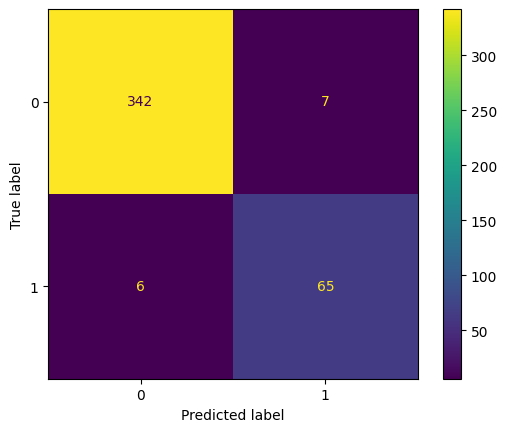

In [33]:
evaluation_parametrics("Confusion Matrix - Validation Dataset", y_valid, y_pred_val)


------------------------Confusion Matrix - Test Dataset------------------------


Classification Report

              precision    recall  f1-score   support

           0       0.96      0.98      0.97       354
           1       0.88      0.80      0.84        66

    accuracy                           0.95       420
   macro avg       0.92      0.89      0.91       420
weighted avg       0.95      0.95      0.95       420

--------------------------------------------------------------------------


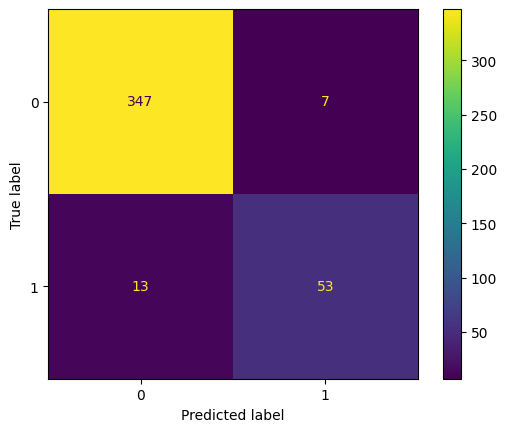

In [34]:
evaluation_parametrics("Confusion Matrix - Test Dataset", y_test, y_pred_test)

In [35]:
model.save('ViT_TBC_CXR.h5')